In [1]:
import os

import anndata
import cooler
import pandas as pd
import scanpy as sc
import scglue

/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid va

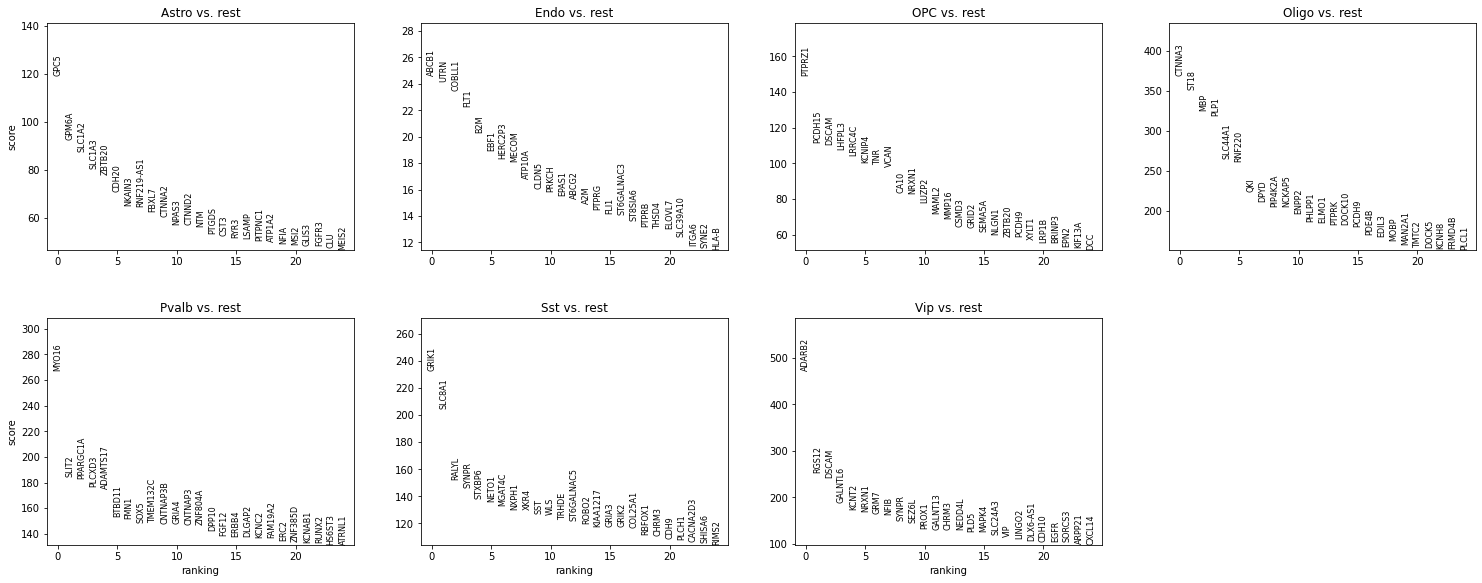

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,...,havana_gene,tag,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std,marker_genes
DDX11L1,chr1,11868.0,14412.0,DDX11L1,.,+,.,.,.,.,...,OTTHUMG00000000961.2,NaN,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
WASH7P,chr1,14362.0,29806.0,WASH7P,.,-,.,.,.,.,...,OTTHUMG00000000958.1,NaN,False,NaN,0.013284,0.013376,0.904079,0.00857,0.084148,False
MIR1302-2,chr9,27656.0,30891.0,MIR1302-2,.,+,.,.,.,.,...,OTTHUMG00000019418.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
FAM138A,chr1,34553.0,36081.0,FAM138A,.,-,.,.,.,.,...,OTTHUMG00000000960.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
OR4G4P,chr1,52472.0,54936.0,OR4G4P,.,+,.,.,.,.,...,OTTHUMG00000185779.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TPTE2P4,chrY,28654359.0,28725837.0,TPTE2P4,.,+,.,.,.,.,...,OTTHUMG00000036765.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
SLC25A15P1,chrY,28732788.0,28737748.0,SLC25A15P1,.,-,.,.,.,.,...,OTTHUMG00000036811.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
PARP4P1,chrY,28740997.0,28780799.0,PARP4P1,.,-,.,.,.,.,...,OTTHUMG00000036812.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False
FAM58CP,chrY,28772666.0,28773306.0,FAM58CP,.,-,.,.,.,.,...,OTTHUMG00000036813.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,False


In [2]:
rna = anndata.read_h5ad("/home/micl/workspace/lmh_data/Human_M1_10x/scRNA.h5ad")
rna.layers["counts"] = rna.X.copy()

scglue.data.get_gene_annotation(
    rna, gtf="/home/micl/workspace/lmh_data/public/gencode.v19.annotation.gtf",
    gtf_by="gene_name"
)
rna = rna[:, rna.var.dropna(axis=0, how='all').index]
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

sc.tl.rank_genes_groups(rna, 'cell_type', method='t-test')
sc.pl.rank_genes_groups(rna, n_genes=25, sharey=False)

marker_genes = pd.DataFrame(rna.uns['rank_genes_groups']['names'])[:10]
marker_genes_index = marker_genes.values.reshape(-1)
rna.var['marker_genes'] = False
rna.var.loc[marker_genes_index, 'marker_genes'] = True
rna.var

In [3]:
rna.var[rna.var['marker_genes']==True]

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,...,havana_gene,tag,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std,marker_genes
RNF220,chr1,44870865.0,45117396.0,RNF220,.,+,.,.,.,.,...,OTTHUMG00000007697.6,ncRNA_host,True,54.0,1.633397,19.891363,5.277870,0.552938,1.142139,True
DPYD,chr1,97543298.0,98386605.0,DPYD,.,-,.,.,.,.,...,OTTHUMG00000039683.3,NaN,True,94.0,1.540498,13.973407,4.058948,0.580011,1.089548,True
TNR,chr1,175284329.0,175712906.0,TNR,.,-,.,.,.,.,...,OTTHUMG00000034876.5,NaN,True,595.0,2.706994,16.864884,1.955942,0.784669,0.805010,True
KCNT2,chr1,196194908.0,196578355.0,KCNT2,.,-,.,.,.,.,...,OTTHUMG00000035611.3,ncRNA_host,True,61.0,2.997459,52.718654,5.125281,0.611961,1.067305,True
SLC8A1,chr2,40324409.0,40838193.0,SLC8A1,.,-,.,.,.,.,...,OTTHUMG00000102183.7,NaN,True,248.0,7.246556,141.110436,2.755749,1.266896,1.291547,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRIK1,chr21,30909253.0,31312351.0,GRIK1,.,-,.,.,.,.,...,OTTHUMG00000078879.1,NaN,True,159.0,26.951277,2199.387471,3.297543,1.955305,1.822247,True
DSCAM,chr21,41382925.0,42219065.0,DSCAM,.,-,.,.,.,.,...,OTTHUMG00000086732.1,ncRNA_host,True,487.0,9.159943,169.155854,2.122101,1.354540,1.383689,True
CLDN5,chr22,19510546.0,19515068.0,CLDN5,.,-,.,.,.,.,...,OTTHUMG00000150441.3,NaN,True,180.0,0.008559,0.029973,3.201898,0.007490,0.134412,True
SEZ6L,chr22,26565439.0,26779562.0,SEZ6L,.,+,.,.,.,.,...,OTTHUMG00000150870.3,NaN,True,637.0,2.060759,10.358692,1.897393,0.693066,0.820022,True


In [4]:
marker_genes

,Astro,Endo,OPC,Oligo,Pvalb,Sst,Vip
0,GPC5,ABCB1,PTPRZ1,CTNNA3,MYO16,GRIK1,ADARB2
1,GPM6A,UTRN,PCDH15,ST18,SLIT2,SLC8A1,RGS12
2,SLC1A2,COBLL1,DSCAM,MBP,PPARGC1A,RALYL,DSCAM
3,SLC1A3,FLT1,LHFPL3,PLP1,PLCXD3,SYNPR,GALNTL6
4,ZBTB20,B2M,LRRC4C,SLC44A1,ADAMTS17,STXBP6,KCNT2
5,CDH20,EBF1,KCNIP4,RNF220,BTBD11,NETO1,NRXN1
6,NKAIN3,HERC2P3,TNR,QKI,FMN1,MGAT4C,GRM7
7,RNF219-AS1,MECOM,VCAN,DPYD,SOX5,NXPH1,NFIB
8,FBXL7,ATP10A,CA10,PIP4K2A,TMEM132C,XKR4,SYNPR
9,CTNNA2,CLDN5,NRXN1,NCKAP5,CNTNAP3B,SST,SEZ6L


In [5]:
folder_path = '/home/micl/workspace/lmh_data/Lee2019/Human_single_cell_10kb_cool'

batchs, celltypes = dict(), dict()
for root, subdirs, files in os.walk(folder_path, topdown=False, followlinks=True):
    for f in files:
        datas = f.split('_')
        if (datas[0], datas[1]) not in batchs.keys():
            batchs[(datas[0], datas[1])] = []
        batchs[(datas[0], datas[1])].append(f)
        if datas[5] not in celltypes.keys():
            celltypes[datas[5]] = []
        celltypes[datas[5]].append(f)

print(batchs.keys())
print(celltypes.keys())

dict_keys([('190315', '29yr'), ('181218', '21yr'), ('190315', '21yr'), ('190305', '21yr'), ('190305', '29yr')])
dict_keys(['ODC', 'Vip', 'L5', 'L23', 'MP', 'Astro', 'L4', 'MG', 'Sst', 'Pvalb', 'L6', 'Ndnf', 'Endo', 'OPC'])


In [6]:
def analyse(filename: str, chrom: str, start: int, end: int, buffer = 20000):
    c = cooler.Cooler(filename)
    binsize, chromsizes = c.binsize, c.chromsizes
    contact = c.pixels(join=True)[:]
#     contact = contact[contact['chrom1']==contact['chrom2']]
    contact = contact[contact['start1']!=contact['start2']]
    _start, _end = int(start/10000)*10000, int(end/10000)*10000
    contact = contact[(contact['chrom1']==chrom)&(contact['start1']==_start)&(contact['start2']<=_end+buffer)]
#     contact = contact[(contact['chrom1']==chrom)&(contact['start1']<=start+buffer)&(contact['start2']>=end-buffer)]
    
    info = contact.groupby(['chrom1', 'start1'])['count'].sum()
    
    _indexs = set([(chrom, int(i * binsize))
                   for chrom in chromsizes.keys()
                   for i in range(int(chromsizes[chrom]/binsize)+1)])
    _indexs -= set(info.index)
    info = pd.concat([info, pd.Series([0]*len(_indexs), index=list(_indexs))]).sort_index()
    info = info[chrom].loc[[_start]]
    return info

def test(batchs_key, celltypes_key, chrom: str, start: str, end: str):
    scores, nums = None, 0
    for filename in batchs[batchs_key]:
        if filename not in celltypes[celltypes_key]:
            continue
        nums += 1
        score = analyse(os.path.join(folder_path, filename), chrom, start, end)
        if scores is not None:
            scores += score
        else:
            scores = score
        if nums == 10:
            break
    scores /= nums
    return scores

In [7]:
cell_types = ['Astro', 'Endo', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip']
def t(celltype):
    result = pd.DataFrame(columns=cell_types)
    for index, row in rna.var.loc[marker_genes[celltype]].iterrows():
        _result = pd.DataFrame(columns=cell_types)
        for t in cell_types:
            _result[t] = test(('190315', '29yr'), t, row['chrom'], int(row['chromStart']), int(row['chromEnd']))
        result = pd.concat([result, _result])
    return result

In [8]:
t('Astro')

,Astro,Endo,ODC,OPC,Pvalb,Sst,Vip
92050000,2.2,1.0,0.7,1.4,1.0,0.6,1.3
176550000,1.7,1.3,1.0,1.5,1.8,1.2,2.6
35270000,0.8,1.1,0.7,1.1,0.9,0.3,1.0
36600000,0.9,0.8,1.2,0.7,0.5,1.3,1.0
114050000,2.5,1.6,2.3,2.2,1.8,1.7,1.5
59000000,0.6,0.6,1.0,0.7,1.1,0.4,0.9
63160000,1.5,0.6,1.2,1.4,0.9,1.0,2.0
78490000,1.4,0.8,1.3,0.6,1.3,1.4,1.3
15500000,1.1,0.9,0.5,0.7,1.0,0.6,0.6
79410000,1.6,0.8,1.1,1.7,1.9,1.6,1.7


In [9]:
t('Endo')

,Astro,Endo,ODC,OPC,Pvalb,Sst,Vip
87130000,1.1,0.8,1.3,1.1,0.6,0.3,0.7
144600000,0.9,1.7,2.5,2.1,1.6,0.9,1.3
165510000,1.3,0.8,1.4,1.7,1.6,1.0,0.9
28870000,0.3,1.2,0.2,0.8,0.9,0.3,0.7
45000000,0.1,0.7,0.9,0.9,1.6,0.9,0.6
158120000,1.2,2.0,1.5,1.7,2.3,1.2,1.3
20580000,0.5,0.9,1.2,0.3,0.5,0.2,1.3
168800000,1.4,1.3,1.8,0.9,2.0,0.6,1.1
25920000,0.5,0.9,1.1,0.7,0.7,0.9,1.0
19510000,0.1,0.2,0.0,0.6,0.1,0.1,0.1


In [11]:
t('OPC')

,Astro,Endo,ODC,OPC,Pvalb,Sst,Vip
121510000,1.6,0.8,0.4,2.0,1.5,1.3,2.0
55560000,0.9,0.9,1.0,1.5,1.0,1.2,0.9
41380000,0.7,0.2,0.7,0.5,1.6,0.4,0.7
103960000,1.3,1.1,1.9,2.6,1.5,0.5,1.4
40130000,0.9,0.7,1.0,1.1,1.5,0.8,0.6
20730000,0.5,1.2,1.0,0.9,1.8,1.1,1.2
175280000,1.4,0.7,1.6,2.2,1.5,1.8,2.6
82760000,0.5,0.8,1.2,0.9,0.8,1.0,0.8
49700000,0.8,0.3,0.4,1.0,0.9,1.0,0.6
50140000,1.0,0.7,1.1,1.4,1.9,1.2,1.5


In [12]:
t('Pvalb')

,Astro,Endo,ODC,OPC,Pvalb,Sst,Vip
109240000,0.8,0.7,0.7,0.8,1.7,1.0,1.5
20250000,0.6,0.6,0.7,0.3,0.5,1.4,0.7
23750000,1.0,0.5,0.6,0.6,0.7,0.4,0.6
41300000,0.4,0.7,0.2,0.7,0.5,0.5,1.0
100510000,0.8,0.8,1.6,1.1,1.3,0.7,2.0
107710000,0.7,1.0,1.2,0.3,1.3,2.0,2.0
33050000,0.7,0.8,1.0,1.0,1.0,1.4,0.6
23680000,0.6,0.5,0.5,0.9,0.7,0.9,0.4
128750000,1.3,1.3,0.8,2.0,1.4,1.4,0.8
43680000,0.0,0.4,0.1,0.1,0.1,0.2,0.2


In [13]:
t('Sst')

,Astro,Endo,ODC,OPC,Pvalb,Sst,Vip
30900000,0.7,0.2,0.7,1.5,1.1,0.2,0.5
40320000,1.0,1.0,1.1,1.0,1.3,0.8,1.0
85090000,0.9,0.4,0.7,0.8,0.8,1.0,0.5
63210000,0.9,0.9,0.8,1.4,0.9,0.9,0.7
25270000,0.6,1.2,1.3,1.2,1.9,1.6,0.3
70400000,0.4,0.8,0.8,0.6,0.6,0.3,0.4
86370000,0.2,0.7,0.8,0.9,0.6,1.9,1.2
8470000,0.5,0.3,0.4,0.6,0.5,0.3,0.5
56010000,0.6,1.1,0.5,1.0,2.4,1.4,1.0
187380000,0.7,0.8,1.0,1.2,1.6,1.6,0.8


In [14]:
t('Vip')

,Astro,Endo,ODC,OPC,Pvalb,Sst,Vip
1220000,0.6,0.3,0.8,0.5,0.7,0.7,0.8
3290000,0.1,0.4,0.5,0.8,0.5,0.9,1.6
41380000,0.7,0.2,0.7,0.5,1.6,0.4,0.7
172730000,1.2,0.7,1.4,0.9,1.6,1.5,2.0
196190000,1.2,0.9,0.8,1.1,1.4,0.6,0.3
50140000,1.0,0.7,1.1,1.4,1.9,1.2,1.5
6810000,0.1,0.8,0.7,1.4,0.9,0.4,0.4
14080000,0.6,0.5,0.6,1.2,1.2,0.5,1.3
63210000,0.9,0.9,0.8,1.4,0.9,0.9,0.7
26560000,0.5,0.5,0.4,1.2,1.1,0.1,0.9
